# F4 Pre Trained Autoencoders Experiments

From:

- https://github.com/CompVis/latent-diffusion#pretrained-autoencoding-models


### KL Autoencoder

In [6]:
import os
import wget
import zipfile

import numpy as np

from PIL import Image

import torchvision.transforms as transforms
import torch
import torch.nn as nn

from ldm.models.autoencoder import AutoencoderKL
from ldm.modules.distributions.distributions import DiagonalGaussianDistribution

In [2]:
def download_pre_trained_ae(url, output_dir):
    if os.path.exists(output_dir):
        print("Used cache")
    else:
        filename = wget.download(url)

        with zipfile.ZipFile(filename, 'r') as zip_ref:
            zip_ref.extractall(output_dir)

        if os.path.exists(filename):
            os.remove(filename)

In [3]:
MODEL_DIR = './pretrained_models/klf4'

download_pre_trained_ae("https://ommer-lab.com/files/latent-diffusion/kl-f4.zip", MODEL_DIR)

Used cache


In [7]:
ddconfig = {
    "double_z": True,
    "z_channels": 3,
    "resolution": 64,
    "in_channels": 3,
    "out_ch": 3,
    "ch": 128,
    "ch_mult": [1,2,4],
    "num_res_blocks": 2,
    "attn_resolutions": [],
    "dropout": 0.0
}
lossconfig = {
      "target": "ldm.modules.losses.LPIPSWithDiscriminator",
      "params": {
        "disc_start": 50001,
        "kl_weight": 1.0e-06,
        "disc_weight": 0.5
      }
}
embed_dim = 3

pl_sd = torch.load(f"{MODEL_DIR}/model.ckpt") #, map_location="cpu"

model = AutoencoderKL(ddconfig, lossconfig, embed_dim)

model.load_state_dict(pl_sd["state_dict"] ,strict=False)

device = torch.device("cuda:0" if (torch.cuda.is_available()) else "cpu")
model.to(device)
model.encoder = nn.DataParallel(model.encoder, list(range(4)))
model.decoder = nn.DataParallel(model.decoder, list(range(4)))

# model.eval()
print()

making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 16, 16) = 768 dimensions.
making attention of type 'vanilla' with 512 in_channels
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth



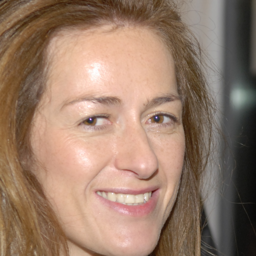

In [8]:
img = Image.open("/data/ffhq/images256x256/40058_256.png")
img.show()

In [9]:
# img = Image.open("/data/ffhq/images256x256/28154_256.png")
# img.show()

In [10]:
# img = Image.open("imagenet1.png")
# img

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

img = transform(img).to(device).unsqueeze(0)

In [12]:
def custom_to_pil(x):
    x = x.detach().cpu()
    x = torch.clamp(x, -1., 1.)
    x = (x + 1.) / 2.
    x = x.permute(1, 2, 0).numpy()
    x = (255 * x).astype(np.uint8)
    x = Image.fromarray(x)
    if not x.mode == "RGB":
        x = x.convert("RGB")
    return x

In [19]:
z = model.encode(img).sample()

print(z.shape)
g_z = z / torch.abs(z).max()

print(torch.abs(z).max())
print(torch.abs(g_z).max())

g_z = g_z * torch.abs(z).max()

output = model.decode(g_z)

torch.Size([1, 3, 16, 16])
tensor(32.5588, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)


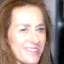

In [20]:
x = output

if len(x.shape) == 4:
    gen_img = custom_to_pil(x[0, ...])
elif len(x.shape) == 3:
    gen_img = custom_to_pil(x)
else:
    gen_img = None

gen_img

In [12]:
model_e_device = "cuda:0"
model_e = model.encoder
quant_conv = torch.nn.Conv2d(2*ddconfig["z_channels"], 2*embed_dim, 1)
model_e.to(model_e_device)
quant_conv.to(model_e_device)

def encode(x):
  with torch.no_grad():
    h = model_e(x)
    moments = quant_conv(h)
    posterior = DiagonalGaussianDistribution(moments)
    return posterior.sample()

In [13]:
model_d_device = "cuda:0"
model_d = model.decoder
post_quant_conv = torch.nn.Conv2d(embed_dim, ddconfig["z_channels"], 1).to(model_d_device)
model_d.to(model_d_device)

def decode(z):
  with torch.no_grad():
    z = post_quant_conv(z)
    return model_d(z)

In [14]:
z = encode(img)
print(z.shape)
output = decode(z)

torch.Size([1, 3, 16, 16])


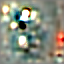

In [15]:
x = output

if len(x.shape) == 4:
    gen_img = custom_to_pil(x[0, ...])
elif len(x.shape) == 3:
    gen_img = custom_to_pil(x)
else:
    gen_img = None

gen_img

In [16]:
output = model.encoder(img)

In [17]:
print(output.min())
print(output.max())
output.shape

tensor(-22.1582, device='cuda:0', grad_fn=<MinBackward1>)
tensor(37.5850, device='cuda:0', grad_fn=<MaxBackward1>)


torch.Size([1, 6, 16, 16])

In [18]:
np.save('latent_z_test.npy', output.cpu().detach().numpy())
latent_z = torch.Tensor(np.load('latent_z_test.npy'))
latent_z.shape

torch.Size([1, 6, 16, 16])

In [19]:
transform = transforms.Compose([
    transforms.Normalize(mean=[0,0,0,0,0,0], std=[128, 128, 128, 128, 128, 128])
])

normalised = transform(latent_z)
print(normalised.min())
print(normalised.max())

tensor(-0.1731)
tensor(0.2936)
